In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import graph_rendering
import landscape as landscapes
import matplotlib.pyplot as plt
import json

# Testing rendering a single path

I first load the landscape from {map_name}.tmx. I don't calculate the value function by setting vf_update_epsilon=-1.
I load the LP output and render the path.


In [3]:
plt.rcParams['figure.dpi'] = 150

import matplotlib.cm as cm

heatmap_colormap = cm.get_cmap('magma')

def get_node_size(landscape):
    return int(100 / (len(landscape.graph.nodes) ** 0.5))

def render_path_heatmap(landscape, paths):
    # Does two steps.
    # 1. Counts up the number of unique paths through a given node
    # 2. Renders the graph with nodes colored by the number of paths going through them
    
    plt.gcf().set_facecolor("white")
    visit_counts = {}
    for path in paths:
        for node in set(path):
            visit_counts[node] = visit_counts.get(node, 0) + 1
    # Some nodes may be visited less than once in the same path.
    # So we normalize by the maximum number of visits to any node.
    max_visit_count = max(visit_counts.values())
    node_colors = {
        node: tuple(int(x * 255) for x in heatmap_colormap(visit_counts[node] / max_visit_count))
        for node in visit_counts.keys()
    }

    render = graph_rendering.render_graph_v2(
        landscape.graph,
        landscape.layout,
        600,
        node_colors,
        node_size=get_node_size(landscape),
        edge_thickness=get_node_size(landscape)//7,
        outline_thickness=get_node_size(landscape)//7,
    )
    plt.imshow(render)

    return render

def render_path(landscape, path):
    plt.gcf().set_facecolor("white")

    render = graph_rendering.render_path_v2(
        landscape.graph,
        landscape.layout,
        600,
        path,
        (255, 255, 255),
        {
            # Goal positions
            **{
                goal: (0, 255, 0) for goal in landscape.available_goals
            },
            # Start position
            landscape.start_positions[0]: (0, 0, 255),
        },
        node_size=get_node_size(landscape),
        edge_thickness=get_node_size(landscape)//7 + 1,
        outline_thickness=get_node_size(landscape)//7 + 1,
    )
    # print(landscape.available_goals, landscape.start_positions)
    plt.imshow(render)

# map_name = '16x16E'
# land = landscapes.load_landscape(f'./gridworlds/square_rect_based/{map_name}.tmx', vf_update_epsilon=-1)
# with open(f"./LP_solutions/{map_name}.json") as f:
#     LP_output = json.load(f)
# print(len(LP_output['policies'][0]['states']))
# path = [(step['agents'][0][1], step['agents'][0][0]) for step in LP_output['policies'][0]['states']]
# render_path(land, path)


# Comparing to ML model

Here I use the ML model to generate a path and time how long it takes


In [4]:
# Scatterplot comparing runtimes

import checkpoints

specs = {
    'exaggeration': {
        'color': (255, 0, 0),
        'extra_time_coefficient': 1.25,
        'checkpoint': checkpoints.models[-1],
        'num_layers': 4,
    },
    'ambiguity': {
        'color': (127, 0, 255),
        'extra_time_coefficient': 1.0,
        'checkpoint': checkpoints.models[-3],
        'num_layers': 2,
    }
}

models = {key: checkpoints.load_checkpoint(specs[key]['checkpoint']) for key in specs}


In [5]:
from run_policy import simulate_environment
import networkx

def get_ml_model_results(land, key, greedy):
    # Finding upper and lower bounds for path length
    graph = land.graph
    start_position = land.start_positions[0] # (4, 7)
    goal_node = land.available_goals[1]
    decoy_node = land.available_goals[0]
    goal_node, decoy_node = decoy_node, goal_node
    goal_distances = land.distance_matrix[goal_node]
    decoy_distances = land.distance_matrix[decoy_node]
    distance_to_goal = goal_distances[start_position]
    distance_to_decoy = decoy_distances[start_position]
    distance_between_goal_and_decoy = networkx.shortest_path_length(graph, goal_node, decoy_node)
    lower = distance_to_goal
    upper = distance_to_decoy + distance_between_goal_and_decoy

    return simulate_environment(
        models[key],
        land,
        land.start_positions[0],
        land.available_goals[0],
        land.available_goals[1],
        specs[key]['num_layers'],
        distance_to_goal + int((upper - lower) * specs[key]['extra_time_coefficient']),
        greedy,
    )



In [58]:
# go through all the results we have so far

import pickle

# The code provided by Deceptive-decision-making (Yagiz's code) provides a dictionary of state-action costs.
# This is what their linear program uses. For consistency, we will compare our paths to their paths along
# this metric, which is the same implementation.
def measure_deceptiveness_from_base_mdp_costs(path, cost_map, grid_height, grid_width):
    total_cost = 0
    row_and_column_to_flat_index = lambda row_number, column_number: (grid_height - 1 - row_number) * grid_width + column_number
    visited = set()
    for i in range(len(path) - 1):
        # Infer action direction
        curr = path[i]
        next = path[i + 1]
        c_row, c_col = curr
        n_row, n_col = next
        if c_row == n_row:
            if c_col < n_col:
                action = 'E'
            else:
                action = 'W'
        else:
            if c_row < n_row:
                action = 'N'
            else:
                action = 'S'

        # flat_state = c_row * grid_width + c_col
        flat_state = row_and_column_to_flat_index(c_row, c_col)

        if (flat_state, action) in cost_map and flat_state not in visited:
            total_cost += cost_map[(flat_state, action)]
            visited.add(flat_state)
        else:
            print("WARN: cost not found in cost map:", path[i], path[i + 1], grid_height, grid_width, action)
            total_cost += 0
    
    return total_cost
    

In [59]:
def run_comparison_to_linear_program(landscape, LP_output, lp_cost_dict, grid_height, grid_width, n_simulations):
    time_for_LP = LP_output['policies'][0]['time']
    # LP_output.policies.0.states[i].step.agents = [[x, y]]
    LP_path = [
        (step['agents'][0][1], step['agents'][0][0])
        for step in LP_output['policies'][0]['states']
    ]
    print("Measuring LP deceptiveness...")
    LP_deceptiveness = measure_deceptiveness_from_base_mdp_costs(LP_path, lp_cost_dict, grid_height, grid_width)

    print("LP path:", LP_path)

    # Simulate several runs of the ML model

    ML_times = []
    ML_paths = []
    ML_deceptivenesses = []
    print("Measuring ML deceptiveness...")
    for i in range(n_simulations):
        ML_output = get_ml_model_results(landscape, 'exaggeration', greedy=False)
        ML_times.append(ML_output['time'])
        ML_paths.append(ML_output['path']['simplified'])
        ML_deceptivenesses.append(measure_deceptiveness_from_base_mdp_costs(ML_paths[-1], lp_cost_dict, grid_height, grid_width))

    shortest_path = networkx.shortest_path(landscape.graph, landscape.start_positions[0], landscape.available_goals[0])
    print("Measuring shortest path deceptiveness...")
    baseline_deceptiveness = measure_deceptiveness_from_base_mdp_costs(shortest_path, lp_cost_dict, grid_height, grid_width)
    
    # creates an encapsulated dictionary of information about each policy
    return {
        "lp": dict(
            time=time_for_LP,
            path=LP_path,
            deceptiveness=LP_deceptiveness,
        ),
        "ml": dict(
            times=ML_times,
            paths=ML_paths,
            deceptivenesses=ML_deceptivenesses,
        ),
        "baseline": dict(
            path=shortest_path,
            deceptiveness=baseline_deceptiveness,
        ),
        "landscape": landscape,
    }



In [60]:
def render_comparison(comparison, out_path=None):
    landscape = comparison['landscape']
    LP_path = comparison['lp']['path']
    ML_paths = comparison['ml']['paths']

    # Set figure size
    plt.rcParams['figure.figsize'] = (6, 4)
    plt.clf()

    # Use subplots to show both renderings side by side
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.title("Linear program planner")
    render_path(landscape, LP_path)

    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.title("ML model planner")
    render_path_heatmap(landscape, ML_paths)

    # Adjust the layout (so images are not squished)
    plt.tight_layout()
    if out_path is not None:
        plt.savefig(out_path)
    plt.show()


In [66]:
import numpy as np

map_names = ['8x8A', '8x8C', '8x8D', '16x16A', '16x16B', '16x16C', '16x16D', '16x16E', 'MediumAmbiguity']

# Runs the ML model 32 times as trials.
n_simulations = 32

comparisons = []

for map_name in map_names:
    if map_name != 'MediumAmbiguity':
        landscape = landscapes.load_landscape(f'./gridworlds/square_rect_based/{map_name}.tmx')
        map_size = int(map_name.split('x')[0])
        grid_height = grid_width = map_size
    else:
        landscape = landscapes.load_landscape(f'./gridworlds/large/MediumAmbiguity.tmx', vf_update_epsilon=-1)
        map_size = 32
        grid_height = grid_width = map_size

    with open(f"./LP_solutions/{map_name}_0.9.json") as f:
        LP_output = json.load(f)
    with open(f"./LP_solutions/{map_name}_0.9.json.mdp_costs", "rb") as f:
        lp_cost_dict = pickle.load(f)

    debug = False
    if debug:
        allow_east = np.zeros((grid_height, grid_width), dtype=bool)
        allow_west = np.zeros((grid_height, grid_width), dtype=bool)
        allow_north = np.zeros((grid_height, grid_width), dtype=bool)
        allow_south = np.zeros((grid_height, grid_width), dtype=bool)
        row_and_column_to_flat_index = lambda row_number, column_number: (grid_height - 1 - row_number) * grid_width + column_number
        for k in lp_cost_dict.keys():
            flat_k, action = k
            col = flat_k % grid_width
            row = grid_height - 1 - (flat_k // grid_width)
            # row = flat_k // grid_width
            # col = flat_k % grid_width
            if action == 'E':
                allow_east[row, col] = True
            elif action == 'W':
                allow_west[row, col] = True
            elif action == 'N':
                allow_north[row, col] = True
            elif action == 'S':
                allow_south[row, col] = True

        allowable_moves_plot = graph_rendering.render_graph_v2(
            landscape.graph,
            landscape.layout,
            600,
            node_colors={n: (0, 0, 0) if allow_east[n] else (255, 255, 255) for n in landscape.graph.nodes},
        )
        plt.rcParams['figure.dpi'] = 150
        plt.imshow(allowable_moves_plot)
        plt.show()

    comparison = run_comparison_to_linear_program(landscape, LP_output, lp_cost_dict, grid_height, grid_width, n_simulations)
    comparisons.append(comparison)


Measuring LP deceptiveness...
LP path: [(1, 0), (0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6)]
Measuring ML deceptiveness...
Trying
Success? True
Speed: 0.03s; 790.60 nodes/s
Path length: 23
Simplified path length: 19
Efficiency: 9 / 23 = 0.391
Number of unique nodes: 22
Trying
Success? False
Speed: 0.03s; 890.11 nodes/s
Trying
Success? True
Speed: 0.03s; 860.01 nodes/s
Path length: 23
Simplified path length: 21
Efficiency: 9 / 23 = 0.391
Number of unique nodes: 21
WARN: cost not found in cost map: (7, 6) (6, 6) 8 8 S
Trying
Success? True
Speed: 0.03s; 742.29 nodes/s
Path length: 23
Simplified path length: 21
Efficiency: 9 / 23 = 0.391
Number of unique nodes: 21
WARN: cost not found in cost map: (7, 0) (7, 1) 8 8 E
WARN: cost not found in cost map: (7, 2) (6, 2) 8 8 S
Trying
Success? True
Speed: 0.03s; 775.06 nodes/s
Path length: 23
Simplified path length: 19
Efficiency: 9 / 23 = 0.391
Number of unique nodes: 20
Trying
Success? True
Speed: 0.03s; 788.93 nodes/s
Path length: 23

In [67]:
# Store comparisons

import pickle

with open("./comparisons.pkl", "wb") as f:
    pickle.dump(comparisons, f)

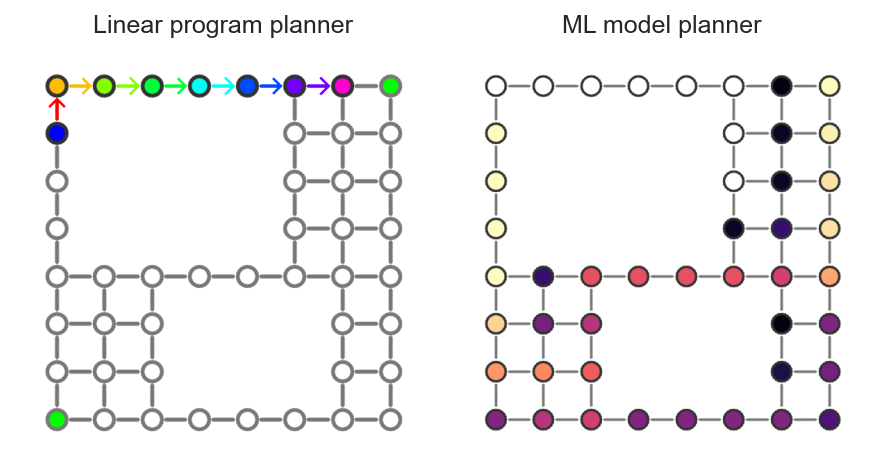

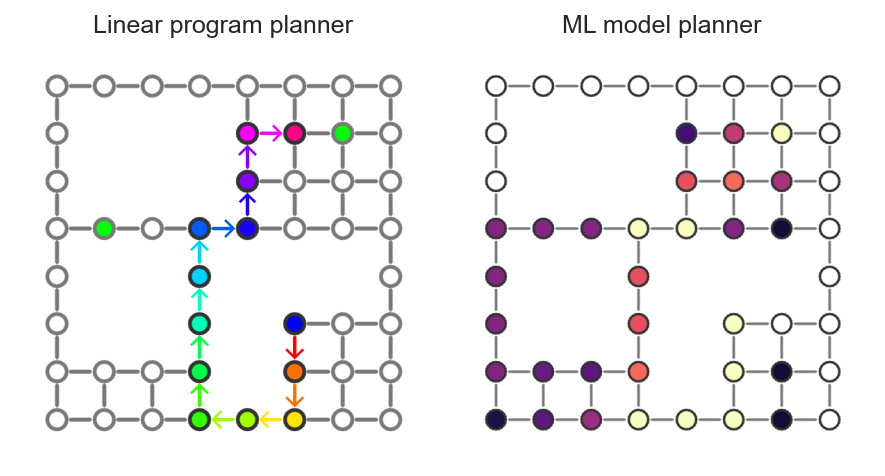

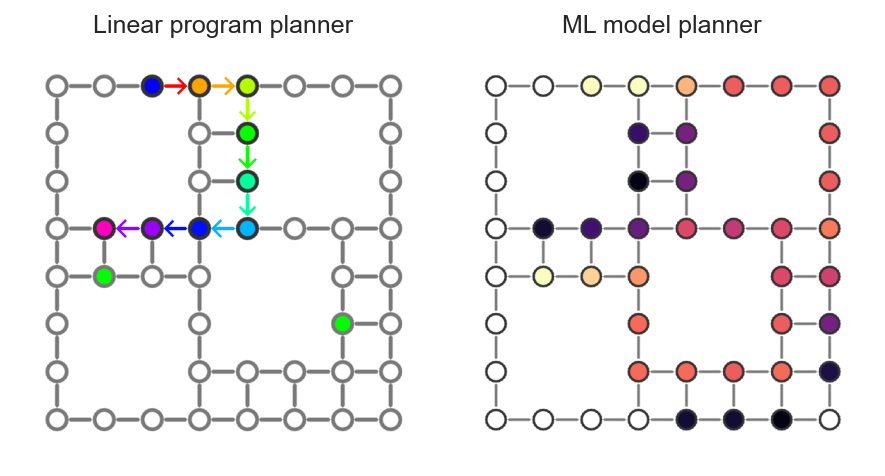

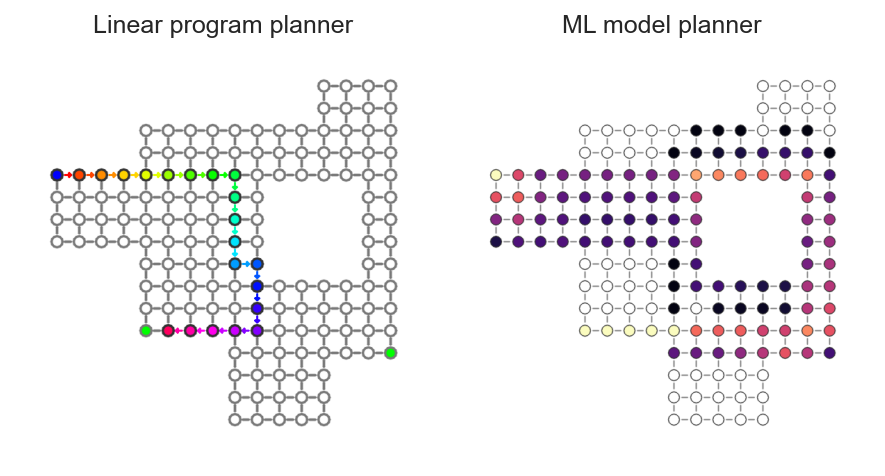

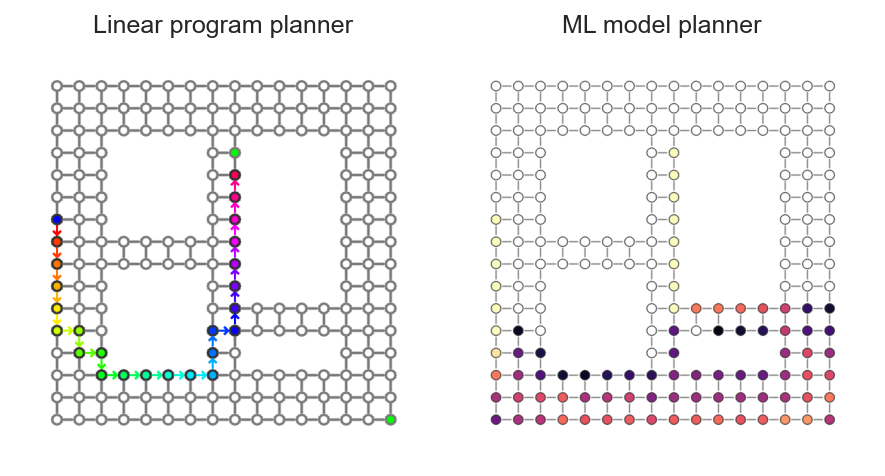

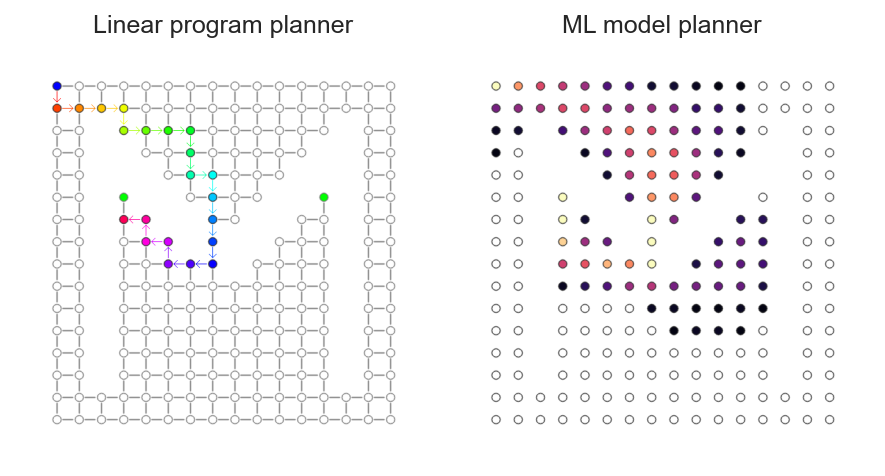

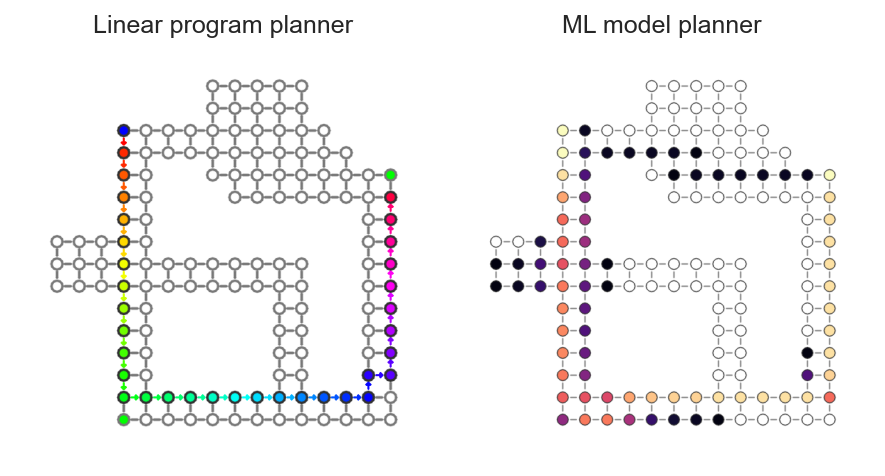

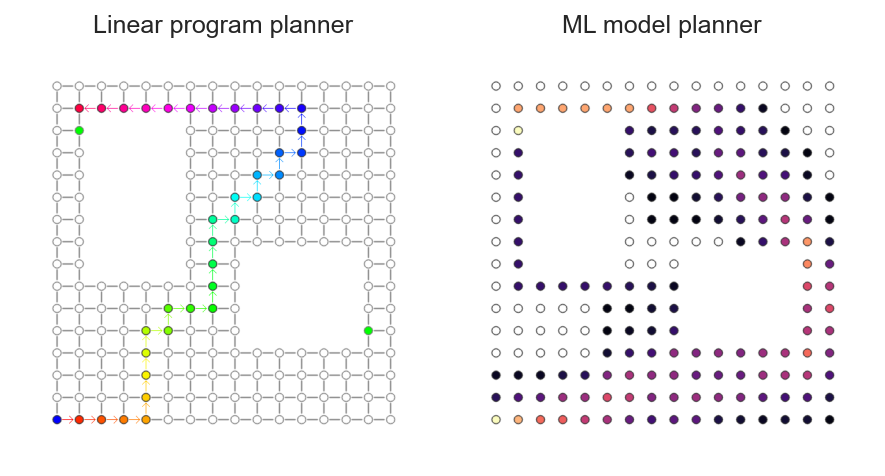

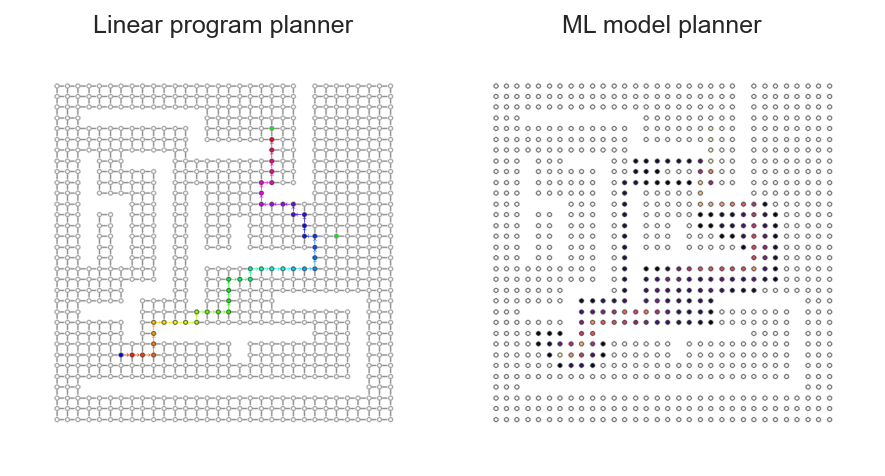

In [68]:
# Process the results

for comparison in comparisons:
    render_comparison(comparison, out_path=f"figures/lp_comparisons/{comparison['landscape'].name}.png")


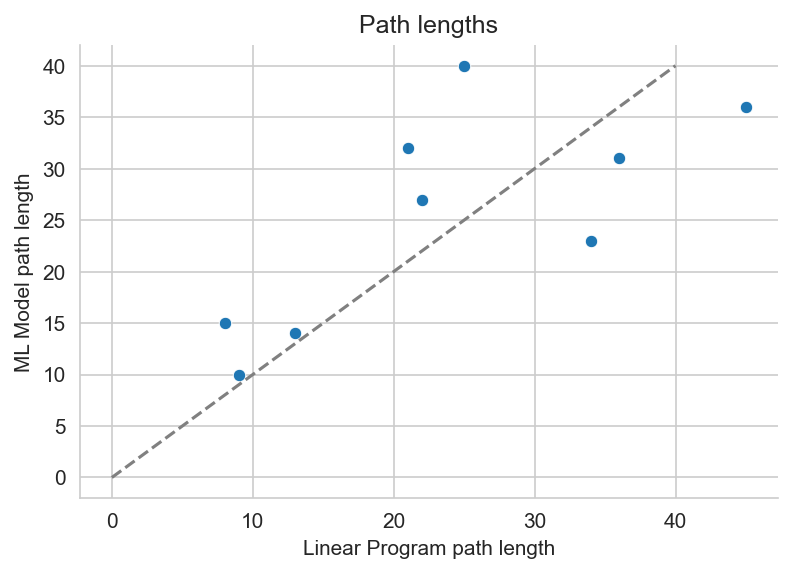

In [69]:
# Compare path lengths
lp_path_lengths = []
ml_model_path_lengths = []

for comparison in comparisons:
    lp_path_lengths.append(len(comparison['lp']['path']))
    ml_model_path_lengths.append(min([len(path) for path in comparison['ml']['paths']]))

import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (6, 4)
plt.clf()
plt.title("Path lengths")
plt.xlabel("Linear Program path length")
plt.ylabel("ML Model path length")
# plt.plot(lp_path_lengths, ml_model_path_lengths, 'o')
sns.scatterplot(x=lp_path_lengths, y=ml_model_path_lengths)
plt.plot([0, 40], [0, 40], '--', color='gray')
sns.despine()
plt.show()


In [70]:
# Compare results

import numpy as np

for comparison in comparisons:
    map_name = comparison['landscape'].name

    ml_times = np.array(comparison['ml']['times'])
    ml_ds = np.array(comparison['ml']['deceptivenesses'])

    ml_time_mean = np.mean(ml_times)
    ml_time_std = np.std(ml_times)

    ml_d_mean = np.mean(ml_ds)
    ml_d_std = np.std(ml_ds)

    print("Map", map_name)
    print(f"ML time: {ml_time_mean:.2f} ± {ml_time_std:.2f}")
    print(f"LP time: {comparison['lp']['time']:.2f}")
    print(f"ML cost: {ml_d_mean:.2f} ± {ml_d_std:.2f}")
    print(f"LP cost: {comparison['lp']['deceptiveness'][0]:.2f}")
    print(f"Shortest path cost: {comparison['baseline']['deceptiveness'][0]:.2f}")
    print()
    

# df = pd.DataFrame({'Map': map_names, 'LP_time': LP_times, 'ML_time': ML_times, 'LP_cost': LP_deceptiveness, 'LP_path_length': LP_path_lengths, 'ML_cost': ML_deceptiveness, 'ML_path_length': ML_path_lengths})
# df.sort_values('Map')


Map 8x8A
ML time: 0.03 ± 0.00
LP time: 1.83
ML cost: 15.55 ± 0.60
LP cost: 13.00
Shortest path cost: 15.00

Map 8x8C
ML time: 0.03 ± 0.00
LP time: 1.50
ML cost: 5.09 ± 0.29
LP cost: 3.00
Shortest path cost: 13.00

Map 8x8D
ML time: 0.03 ± 0.00
LP time: 1.47
ML cost: 9.06 ± 0.35
LP cost: 6.99
Shortest path cost: 11.00

Map 16x16A
ML time: 0.07 ± 0.02
LP time: 7.31
ML cost: 25.70 ± 3.82
LP cost: 16.73
Shortest path cost: 21.00

Map 16x16B
ML time: 0.08 ± 0.01
LP time: 11.58
ML cost: 17.00 ± 0.00
LP cost: 15.00
Shortest path cost: 25.00

Map 16x16C
ML time: 0.08 ± 0.01
LP time: 9.10
ML cost: 61.87 ± 12.41
LP cost: 39.66
Shortest path cost: 41.66

Map 16x16D
ML time: 0.05 ± 0.00
LP time: 6.71
ML cost: 23.65 ± 1.35
LP cost: 21.08
Shortest path cost: 27.00

Map 16x16E
ML time: 0.08 ± 0.01
LP time: 8.70
ML cost: 23.24 ± 0.77
LP cost: 20.94
Shortest path cost: 26.00

Map MediumAmbiguity
ML time: 0.10 ± 0.02
LP time: 148.30
ML cost: 24.21 ± 10.47
LP cost: 17.78
Shortest path cost: 50.48

